In [4]:
using DrWatson
@quickactivate "MEngProject"
using MEngProject,
    CUDA,
    DifferentialEquations,
    PyPlot,
    NNlib,
    ImageFiltering,
    Images,
    MEngProject.LaminartKernels,
    MEngProject.LaminartInitFunc,
    MEngProject.Utils,
    BenchmarkTools,
    Test

using OrdinaryDiffEq,
    ParameterizedFunctions, LSODA, Sundials, DiffEqDevTools, Noise;

In [27]:
batch = 10


global bm
global benchm_i = []
global prob

In [51]:

tspan = (0.0f0, 10f0)

batch_ = string(batch, "_", rand(1000:9999))
mkdir(plotsdir(string("bench_imp", batch_)))
file = "kan_sq_cont_l.png"

test_name_plt = [
    "GPU conv",
#     "CPU conv",
#     "CPU imfilter",
#     "GPU imfilter FFT",
#     "GPU imfilter FIR",
#     "GPU imfilter IIR",
];

In [35]:
# GPU
p = LaminartInitFunc.parameterInit_conv_gpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = cu(reshape(
    zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
    p.dim_i,
    p.dim_j,
    5 * p.K + 2,
    1,
))

arr1 = similar(u0[:, :, 1:2, :])
arr2 = similar(u0[:, :, 1:1, :])

f = LaminartFunc.LamFunction(
    arr1, #x
    similar(arr1), #m
    similar(arr1), #s
    arr2, #x_lgn,
    similar(arr1), #C,
    similar(arr1), #H_z,
    similar(arr1), # dy_temp,
    similar(arr1), # dm_temp,
    similar(arr1), # dz_temp,
    similar(arr1), # ds_temp,
    similar(arr2), # dv_temp,
    similar(arr1), # H_z_temp,
    similar(arr2), #  V_temp_1,
    similar(arr2), #  V_temp_2,
    similar(arr1), #  A_temp,
    similar(arr1), #   B_temp
)
prob = ODEProblem(f, u0, tspan, p)
bm = @benchmark solve(prob)
push!(benchm_i, bm)

CUDA.CuError: CUDA error (code 2, CUDA_ERROR_OUT_OF_MEMORY)

In [58]:
# CPU conv

p = LaminartInitFunc.parameterInit_conv_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(
    zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
    p.dim_i,
    p.dim_j,
    5 * p.K + 2,
    1,
)

    arr1 = similar(u0[:, :, 1:2, :])
    arr2 = similar(u0[:, :, 1:1, :])

f = LaminartFunc.LamFunction(
    arr1, #x
    similar(arr1), #m
    similar(arr1), #s
    arr2, #x_lgn,
    similar(arr1), #C,
    similar(arr1), #H_z,
    similar(arr1), # dy_temp,
    similar(arr1), # dm_temp,
    similar(arr1), # dz_temp,
    similar(arr1), # ds_temp,
    similar(arr2), # dv_temp,
    similar(arr1), # H_z_temp,
    similar(arr2), #  V_temp_1,
    similar(arr2), #  V_temp_2,
    similar(arr1), #  A_temp,
    similar(arr1), #   B_temp
)
prob = ODEProblem(f, u0, tspan, p)
# bm = @benchmark solve(prob)
# push!(benchm_i, bm)

 @benchmark solve(prob)

BenchmarkTools.Trial: 
  memory estimate:  19.83 GiB
  allocs estimate:  118491
  --------------
  minimum time:     23.889 s (3.11% GC)
  median time:      23.889 s (3.11% GC)
  mean time:        23.889 s (3.11% GC)
  maximum time:     23.889 s (3.11% GC)
  --------------
  samples:          1
  evals/sample:     1

In [75]:
# CPU imfilter

p = LaminartInitFunc.parameterInit_imfil_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2);


arr1 = u0[:, :, 1:p.K]
arr2 = u0[:, :, 1];


f = LaminartFunc.LamFunction_imfil_cpu(
 arr2, #x_lgn,
arr1, #C,
similar(arr1), #H_z,
    similar(arr1), # H_z_temp,
    similar(arr2), # v_C_temp1,
    similar(arr2), # v_C_temp2,
    similar(arr1), # v_C_tempA,
    similar(arr1[:,:,1]), #W_temp
    );

prob = ODEProblem(f, u0, tspan, p)
solve(prob)
bm = @benchmark solve(prob)
push!(benchm_i, bm)

4-element Array{Any,1}:
 Trial(23.992 s)
 Trial(24.187 s)
 Trial(23.944 s)
 Trial(28.050 s)

In [69]:
tspan = (0.0f0, 100f0)
u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2);

arr1 = u0[:, :, 1:p.K]
arr2 = u0[:, :, 1];

f = LaminartFunc.LamFunction_imfil_cpu(
 similar(arr2), #x_lgn,
similar(arr1), #C,
similar(arr1), #H_z,
    similar(arr1), # H_z_temp,
    similar(arr2), # v_C_temp1,
    similar(arr2), # v_C_temp2,
    similar(arr1), # v_C_tempA,
    similar(arr1[:,:,1]), #W_temp
    );

prob = ODEProblem(f, u0, tspan, p);

In [70]:
solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 199-element Array{Float32,1}:
   0.0
   1.0f-6
   9.185681f-6
   5.854164f-5
   0.0002891622
   0.0011657982
   0.0039884993
   0.011947116
   0.03275598
   0.084288046
   0.19040538
   0.3501516
   0.5611292
   ⋮
  94.15206
  94.71599
  95.28943
  95.85221
  96.38673
  96.89092
  97.38516
  97.894745
  98.428154
  98.98569
  99.55772
 100.0
u: 199-element Array{Array{Float32,3},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;

In [ ]:
# GPU imfilter FFT

p = LaminartInitFunc.parameterInit_imfil_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(
    zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
    p.dim_i,
    p.dim_j,
    5 * p.K + 2,
)


f = LaminartFunc.LamFunction_imfil_cpu(
    arr2, #x_lgn,
    arr1, #C,
    similar(arr1), #H_z,
    similar(arr1), # H_z_temp,
    similar(arr2), # v_C_temp1,
    similar(arr2), # v_C_temp2,
    similar(arr1), # v_C_tempA,
    similar(arr1[:, :, 1]), #W_temp
)
prob = ODEProblem(f, u0, tspan, p)
bm = @benchmark solve(prob)
push!(benchm_i, bm)

In [ ]:
# GPU imfilter IIR

p = LaminartInitFunc.parameterInit_imfil_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(
    zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
    p.dim_i,
    p.dim_j,
    5 * p.K + 2,
)


f = LaminartFunc.LamFunction_imfil_cpu(
    arr2, #x_lgn,
    arr1, #C,
    similar(arr1), #H_z,
    similar(arr1), # H_z_temp,
    similar(arr2), # v_C_temp1,
    similar(arr2), # v_C_temp2,
    similar(arr1), # v_C_tempA,
    similar(arr1[:, :, 1]), #W_temp
)
prob = ODEProblem(f, u0, tspan, p)
bm = @benchmark solve(prob)
push!(benchm_i, bm)

In [ ]:
# GPU imfilter FIR

p = LaminartInitFunc.parameterInit_imfil_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(
    zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
    p.dim_i,
    p.dim_j,
    5 * p.K + 2,
)



f = LaminartFunc.LamFunction_imfil_cpu(
    arr2, #x_lgn,
    arr1, #C,
    similar(arr1), #H_z,
    similar(arr1), # H_z_temp,
    similar(arr2), # v_C_temp1,
    similar(arr2), # v_C_temp2,
    similar(arr1), # v_C_tempA,
    similar(arr1[:, :, 1]), #W_temp
)
prob = ODEProblem(f, u0, tspan, p)
bm = @benchmark solve(prob)
push!(benchm_i, bm)

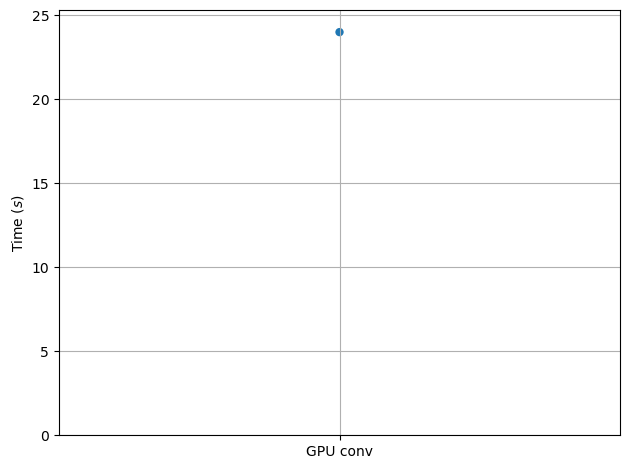

In [62]:
# benchmark plot

# time
fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        median(benchm_i[ben[1]].times) * 1e-9,
        color = Utils.colours[ben[1]],
        edgecolors = "none",
    )
end
# ax.legend()
ax.set_ylabel("Time (\$s\$)")
ax.set_ylim(ymin=0)
ax.grid(true)
fig.tight_layout()
plt.savefig(plotsdir(string("bench_imp", batch_), string("bench_imp_time.png")))
# close("all")

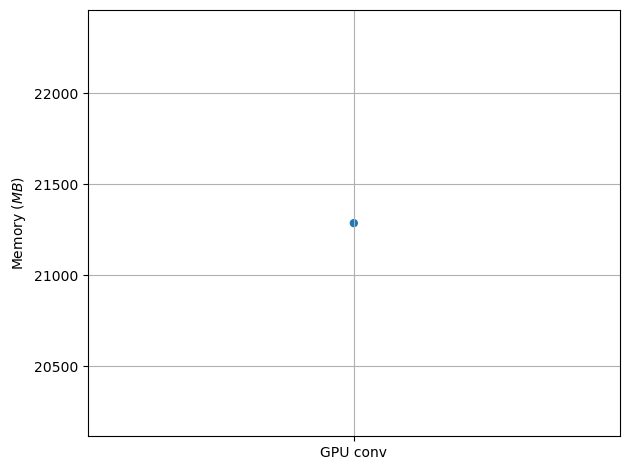

In [59]:
# memory

fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        benchm_i[ben[1]].memory * 1e-6,
        color = Utils.colours[ben[1]],
        edgecolors = "none",
    )
end


# ax.legend()
ax.set_ylabel("Memory (\$MB\$)")
ax.grid(true)
fig.tight_layout()
plt.savefig(plotsdir(string("bench_imp", batch_), string("bench_imp_mem.png")))
# close("all")

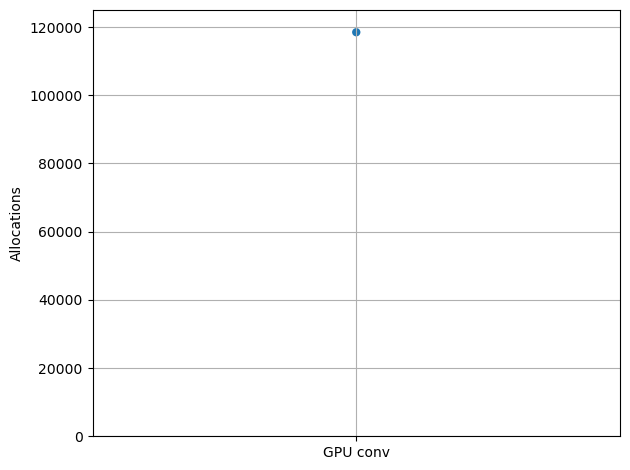

In [61]:
# alloc

fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        benchm_i[ben[1]].allocs,
        color = Utils.colours[ben[1]],
        edgecolors = "none",
    )
end


# ax.legend()
ax.set_ylabel("Allocations")
ax.set_ylim(ymin=0)
ax.grid(true)
fig.tight_layout()
plt.savefig(plotsdir(
    string("bench_imp", batch_),
    string("bench_imp_alloc.png"),
))
# close("all")